In [12]:
"""
    This notebook is used to generate the figures for the following section:
    "An Efficient Algorithm to Generate Degenerate Populations"
"""

'\n    This notebook is used to generate the figures for the following section:\n    "An Efficient Algorithm to Generate Degenerate Populations"\n'

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd

from stg import simulate_individual_t_eval, get_default_u0, get_default_parameters
import warnings
from utils import simulate_population_t_eval_multiprocessing, get_spiking_times
from stg import generate_neuromodulated_population
from stg import DICs
from inference import SpikeFeatureExtractor
from multiprocessing import Pool
from tqdm.notebook import tqdm

V_th = -51.
N = 500
set_to_compensate = ['A', 'CaS']

spfe = SpikeFeatureExtractor(model="stg")

# Wrapper to simulate the population using multiprocessing
def simulate_population(population, U0 = get_default_u0(), T_EVAL = np.arange(3000, 4500, 0.5), PARAMS=get_default_parameters(), MAX_WORKERS=16):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        return np.asarray(simulate_population_t_eval_multiprocessing(simulate_individual_t_eval, population, U0, T_EVAL, PARAMS, MAX_WORKERS, verbose=True))[:, 1, :]
    

def get_spiking_times_wrapper(args):
    return get_spiking_times(*args)[1]
    
def get_spiking_times_population(V_population, T_EVAL, MAX_WORKERS):
        with Pool(MAX_WORKERS) as pool:
            spiking_times = list(tqdm(pool.imap(get_spiking_times_wrapper, [(T_EVAL, c) for c in V_population]), total=len(V_population)))
        return spiking_times

In [14]:
# Strong bursting

g_s_strong_bursting = -4.
g_u_strong_bursting = 5.

population_strong_bursting = generate_neuromodulated_population(N, V_th, g_s_strong_bursting, g_u_strong_bursting, set_to_compensate)
print(population_strong_bursting.shape)
print(population_strong_bursting[0])
T_EVAL = np.arange(3000, 4500, 0.05)
MAX_WORKERS = 19

V_strong_bursting = simulate_population(population_strong_bursting, T_EVAL=T_EVAL, MAX_WORKERS=MAX_WORKERS)
print(V_strong_bursting.shape)

spiking_times_strong_bursting = get_spiking_times_population(V_strong_bursting, T_EVAL, MAX_WORKERS)
# spiking_times_strong_bursting is a list of list. We make it a pandas DataFrame with a column 'spiking_times', one row per neuron
spiking_times_strong_bursting = pd.DataFrame({'spiking_times': [spiking_times_strong_bursting[i] for i in range(N)]})
print(spiking_times_strong_bursting.head())

features_strong_bursting = spfe.extract_from_dataframe(spiking_times_strong_bursting, verbose=True, num_workers=MAX_WORKERS, should_preprocess=False)

(500, 8)
[7.80268843e+03 1.08718748e+02 8.10403241e+00 2.88530815e+01
 1.94540939e+02 2.72921488e+02 3.79176036e-01 1.25781055e-02]


Simulating population (multiprocessing): 100%|██████████| 500/500 [03:13<00:00,  2.59it/s]


(500, 30000)


  0%|          | 0/500 [00:00<?, ?it/s]

                                       spiking_times
0  [3105.4000000003834, 3114.650000000417, 3123.2...
1  [3019.850000000072, 3033.1500000001206, 3045.7...
2  [3104.8000000003813, 3116.500000000424, 3127.5...
3  [3074.500000000271, 3084.900000000309, 3094.90...
4  [3018.9000000000688, 3030.8500000001122, 3041....
Extracting features from 500 samples using 19 workers


100%|██████████| 19/19 [00:00<00:00, 441.61it/s]


6804.7722486209095
103.79573763932189
4.97847107379393
29.15123118697443
159.12810911560652
295.14007571261317
0.33106408433849505
0.0104232816850956


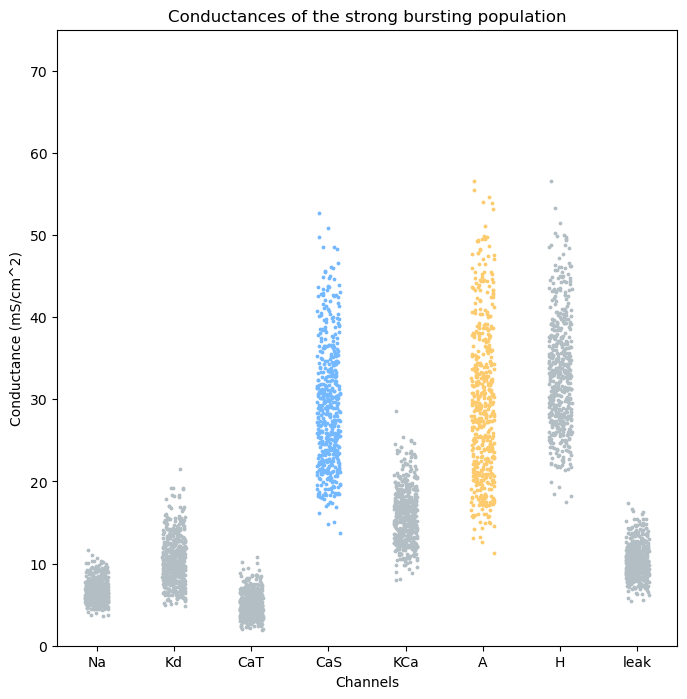

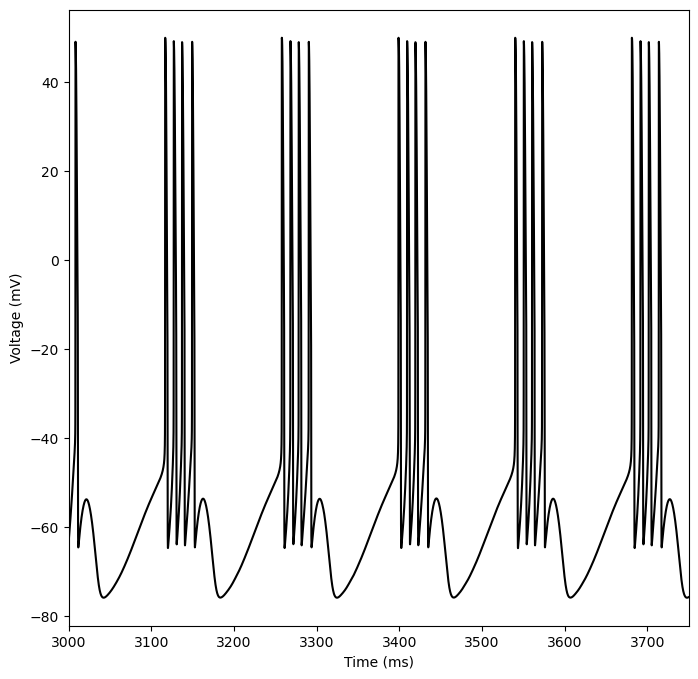

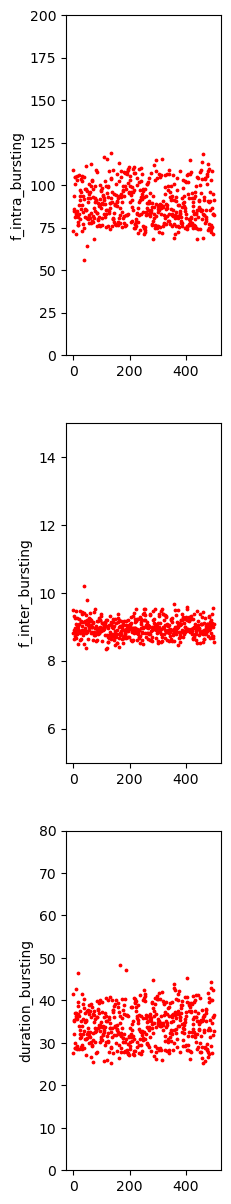

In [63]:
# 1. Plot of the CaS and A distributions, as two set of scatter plots (so x = 'CaS' and y = CaS value, one point per neuron, same for A)

fig, ax1 = plt.subplots(figsize=(8, 8))

# Plot the CaS values
eps = 0.3
x_offset = (np.arange(N) - N/2) / N * eps

x_label = ['Na', 'Kd', 'CaT', 'CaS', 'KCa', 'A', 'H', 'leak']
scaling = [1e-3, 1e-1, 1, 1, 1e-1, 1e-1, 1e2, 1e3]

for i in range(len(population_strong_bursting[0])):
    m = np.mean(population_strong_bursting[:, i])
    print(m)
    c = '#b2bec3ff'
    if i == 3:
        c = '#74b9ff'
    if i == 5:
        c = '#fdcb6e'
    ax1.scatter(i + x_offset, population_strong_bursting[:, i]*scaling[i], color=c, s = 3)
ax1.set_xticks(range(len(x_label)))
ax1.set_xticklabels(x_label)
ax1.set_ylabel('Conductance (mS/cm^2)')
ax1.set_ylim([0, 75])
ax1.set_xlabel('Channels')
ax1.set_title('Conductances of the strong bursting population')

plt.savefig('figures/conductances_strong_bursting.svg')
plt.show()

# 2. Make the trace plot of the first neuron in the population
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(T_EVAL, V_strong_bursting[len(V_strong_bursting)//2], color='black')
ax.set_xlabel('Time (ms)')
ax.set_xlim([3000, 3750])
ax.set_ylabel('Voltage (mV)')
plt.savefig('figures/trace_strong_bursting.svg')
plt.show()

# 3. Plot the features of the population

ylim = [(0, 200), (5, 15), (0, 80), (3, 5)]

# Other try, same but not sorted
fig, axs = plt.subplots(3, 1, figsize=(2, 15))

for i, feature in enumerate(["f_intra_bursting", "f_inter_bursting", "duration_bursting"]):
    d = features_strong_bursting[feature]
    axs[i].scatter(range(N), d, color='red', s = 3)
    axs[i].set_ylim(ylim[i])
    axs[i].set_ylabel(feature)

plt.savefig('figures/features_strong_bursting.svg')
plt.show()


In [34]:
# Light bursting

g_s_light_bursting = -3.
g_u_light_bursting = 5.

population_light_bursting = generate_neuromodulated_population(N, V_th, g_s_light_bursting, g_u_light_bursting, set_to_compensate)
print(population_light_bursting.shape)
T_EVAL = np.arange(3000, 4500, 0.05)
MAX_WORKERS = 19

V_light_bursting = simulate_population(population_light_bursting, T_EVAL=T_EVAL, MAX_WORKERS=MAX_WORKERS)
print(V_light_bursting.shape)

spiking_times_light_bursting = get_spiking_times_population(V_light_bursting, T_EVAL, MAX_WORKERS)
# spiking_times_light_bursting is a list of list. We make it a pandas DataFrame with a column 'spiking_times', one row per neuron
spiking_times_light_bursting = pd.DataFrame({'spiking_times': [spiking_times_light_bursting[i] for i in range(N)]})
print(spiking_times_light_bursting.head())

features_light_bursting = spfe.extract_from_dataframe(spiking_times_light_bursting, verbose=True, num_workers=MAX_WORKERS, should_preprocess=False)

(500, 8)


Simulating population (multiprocessing): 100%|██████████| 500/500 [02:18<00:00,  3.62it/s]


(500, 30000)


  0%|          | 0/500 [00:00<?, ?it/s]

                                       spiking_times
0  [3084.2000000003063, 3095.4500000003472, 3106....
1  [3005.0500000000184, 3098.150000000357, 3114.7...
2  [3094.4000000003434, 3105.6500000003844, 3116....
3  [3004.100000000015, 3105.4000000003834, 3118.9...
4  [3083.350000000303, 3098.350000000358, 3116.75...
Extracting features from 500 samples using 19 workers


100%|██████████| 19/19 [00:00<00:00, 1158.46it/s]


6766.158166866639
102.60247148521711
4.936819087063128
26.76761349963818
158.38610227254557
296.69581594892617
0.32921379150705105
0.010401865419526889


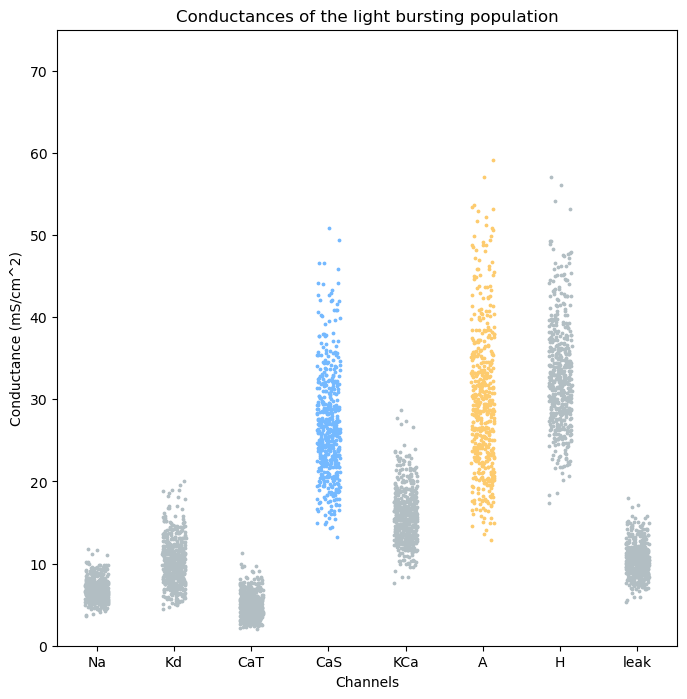

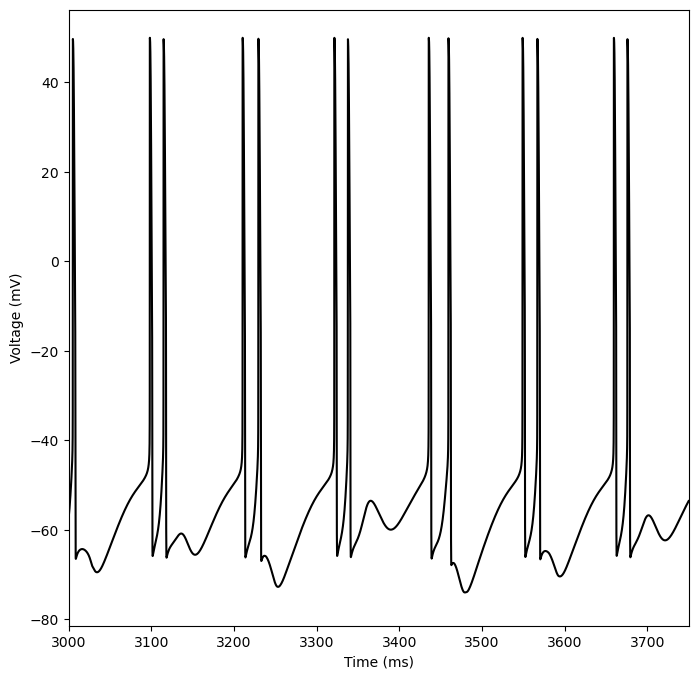

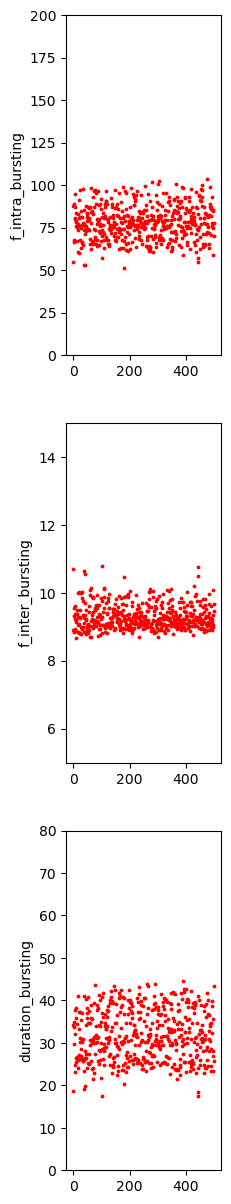

In [64]:
# 1. Plot of the CaS and A distributions, as two set of scatter plots (so x = 'CaS' and y = CaS value, one point per neuron, same for A)

fig, ax1 = plt.subplots(figsize=(8, 8))

# Plot the CaS values
eps = 0.3
x_offset = (np.arange(N) - N/2) / N * eps

x_label = ['Na', 'Kd', 'CaT', 'CaS', 'KCa', 'A', 'H', 'leak']
scaling = [1e-3, 1e-1, 1, 1, 1e-1, 1e-1, 1e2, 1e3]

for i in range(len(population_light_bursting[0])):
    m = np.mean(population_light_bursting[:, i])
    print(m)
    c = '#b2bec3ff'
    if i == 3:
        c = '#74b9ff'
    if i == 5:
        c = '#fdcb6e'
    ax1.scatter(i + x_offset, population_light_bursting[:, i]*scaling[i], color=c, s = 3)
ax1.set_xticks(range(len(x_label)))
ax1.set_xticklabels(x_label)
ax1.set_ylim([0, 75])
ax1.set_ylabel('Conductance (mS/cm^2)')
ax1.set_xlabel('Channels')
ax1.set_title('Conductances of the light bursting population')

plt.savefig('figures/conductances_light_bursting.svg')
plt.show()

# 2. Make the trace plot of the first neuron in the population
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(T_EVAL, V_light_bursting[1], color='black')
ax.set_xlabel('Time (ms)')
ax.set_xlim([3000, 3750])
ax.set_ylabel('Voltage (mV)')
plt.savefig('figures/trace_light_bursting.svg')
plt.show()

# 3. Plot the features of the population

ylim = [(0, 200), (5, 15), (0, 80), (3, 5)]

# Other try, same but not sorted
fig, axs = plt.subplots(3, 1, figsize=(2, 15))

for i, feature in enumerate(["f_intra_bursting", "f_inter_bursting", "duration_bursting"]):
    d = features_light_bursting[feature]
    axs[i].scatter(range(N), d, color='red', s = 3)
    axs[i].set_ylim(ylim[i])
    axs[i].set_ylabel(feature)

plt.savefig('figures/features_light_bursting.svg')
plt.show()


In [18]:
# tonic spiking

g_s_tonic_spiking = 4.
g_u_tonic_spiking = 5.

population_tonic_spiking = generate_neuromodulated_population(N, V_th, g_s_tonic_spiking, g_u_tonic_spiking, set_to_compensate)
print(population_tonic_spiking.shape)
print(population_tonic_spiking[0])
T_EVAL = np.arange(3000, 4500, 0.05)
MAX_WORKERS = 19

V_tonic_spiking = simulate_population(population_tonic_spiking, T_EVAL=T_EVAL, MAX_WORKERS=MAX_WORKERS)
print(V_tonic_spiking.shape)

spiking_times_tonic_spiking = get_spiking_times_population(V_tonic_spiking, T_EVAL, MAX_WORKERS)
# spiking_times_tonic_spiking is a list of list. We make it a pandas DataFrame with a column 'spiking_times', one row per neuron
spiking_times_tonic_spiking = pd.DataFrame({'spiking_times': [spiking_times_tonic_spiking[i] for i in range(N)]})
print(spiking_times_tonic_spiking.head())

features_tonic_spiking = spfe.extract_from_dataframe(spiking_times_tonic_spiking, verbose=True, num_workers=MAX_WORKERS, should_preprocess=False)

(500, 8)
[5.67315124e+03 1.08243216e+02 5.19275271e+00 1.05523260e+01
 1.46927582e+02 2.93146458e+02 2.76050351e-01 8.83599231e-03]


Simulating population (multiprocessing): 100%|██████████| 500/500 [01:47<00:00,  4.65it/s]


(500, 30000)


  0%|          | 0/500 [00:00<?, ?it/s]

                                       spiking_times
0  [3039.2000000001426, 3119.800000000436, 3200.4...
1  [3030.1000000001095, 3100.050000000364, 3170.0...
2  [3048.050000000175, 3124.200000000452, 3200.40...
3  [3036.000000000131, 3118.500000000431, 3201.00...
4  [3000.4500000000016, 3084.0500000003058, 3167....
Extracting features from 500 samples using 19 workers


100%|██████████| 19/19 [00:00<00:00, 265.32it/s]


6921.2281804338
104.5085226059426
5.007836948822873
14.966442422858654
160.15898369416345
379.81630062164714
0.33671975094017953
0.010547565471680141


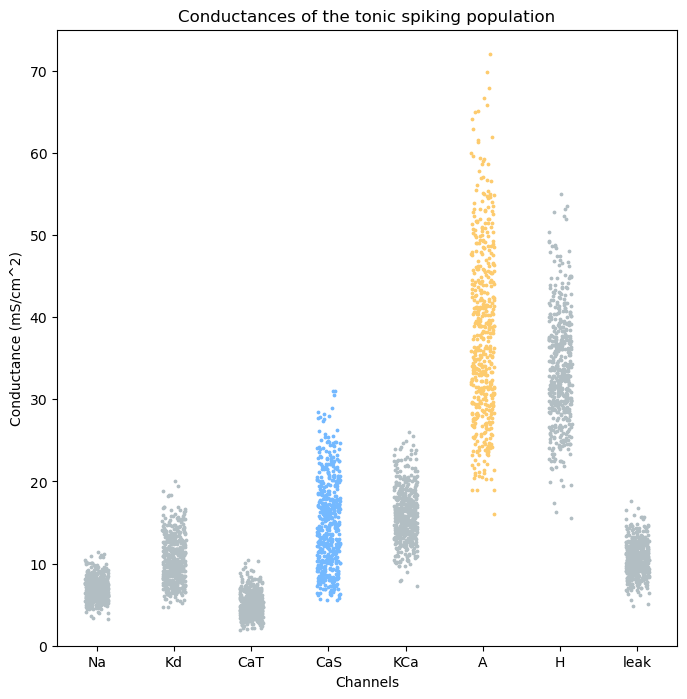

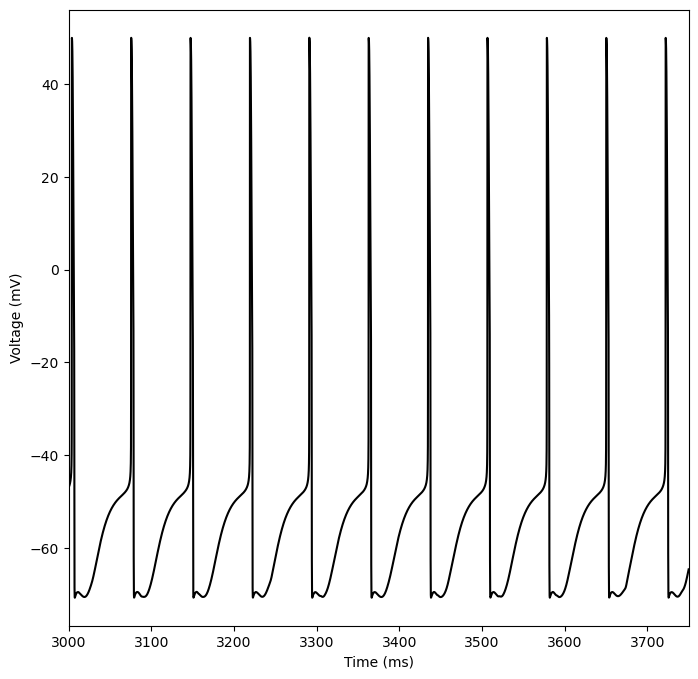

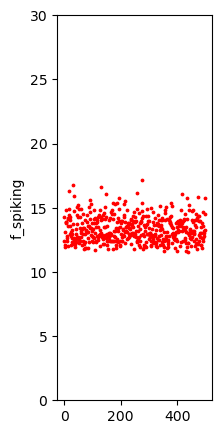

In [67]:
# 1. Plot of the CaS and A distributions, as two set of scatter plots (so x = 'CaS' and y = CaS value, one point per neuron, same for A)

fig, ax1 = plt.subplots(figsize=(8, 8))

# Plot the CaS values
eps = 0.3
x_offset = (np.arange(N) - N/2) / N * eps

x_label = ['Na', 'Kd', 'CaT', 'CaS', 'KCa', 'A', 'H', 'leak']
scaling = [1e-3, 1e-1, 1, 1, 1e-1, 1e-1, 1e2, 1e3]

for i in range(len(population_tonic_spiking[0])):
    m = np.mean(population_tonic_spiking[:, i])
    print(m)
    c = '#b2bec3ff'
    if i == 3:
        c = '#74b9ff'
    if i == 5:
        c = '#fdcb6e'
    ax1.scatter(i + x_offset, population_tonic_spiking[:, i]*scaling[i], color=c, s = 3)
ax1.set_xticks(range(len(x_label)))
ax1.set_xticklabels(x_label)
ax1.set_ylabel('Conductance (mS/cm^2)')
ax1.set_xlabel('Channels')
ax1.set_ylim([0, 75])
ax1.set_title('Conductances of the tonic spiking population')

plt.savefig('figures/conductances_tonic_spiking.svg')
plt.show()

# 2. Make the trace plot of the first neuron in the population
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(T_EVAL, V_tonic_spiking[len(V_tonic_spiking)//2], color='black')
ax.set_xlabel('Time (ms)')
ax.set_xlim([3000, 3750])
ax.set_ylabel('Voltage (mV)')
plt.savefig('figures/trace_tonic_spiking.svg')
plt.show()

# 3. Plot the features of the population

ylim = [(0, 30)]

# Other try, same but not sorted
fig, axs = plt.subplots(1, 1, figsize=(2, 5))
axs = [axs]

for i, feature in enumerate(["f_spiking"]):
    d = features_tonic_spiking[feature]
    axs[i].scatter(range(N), d, color='red', s = 3)
    axs[i].set_ylim(ylim[i])
    axs[i].set_ylabel(feature)

plt.savefig('figures/features_tonic_spiking.svg')
plt.show()


(500, 8)
(500, 8)
(500, 8)
6883.861933447224
105.22974538808535
4.987737477490302
2.355375356142381
160.70805782513548
-172.51532624798602
0.33488964062319176
0.010534182601301961


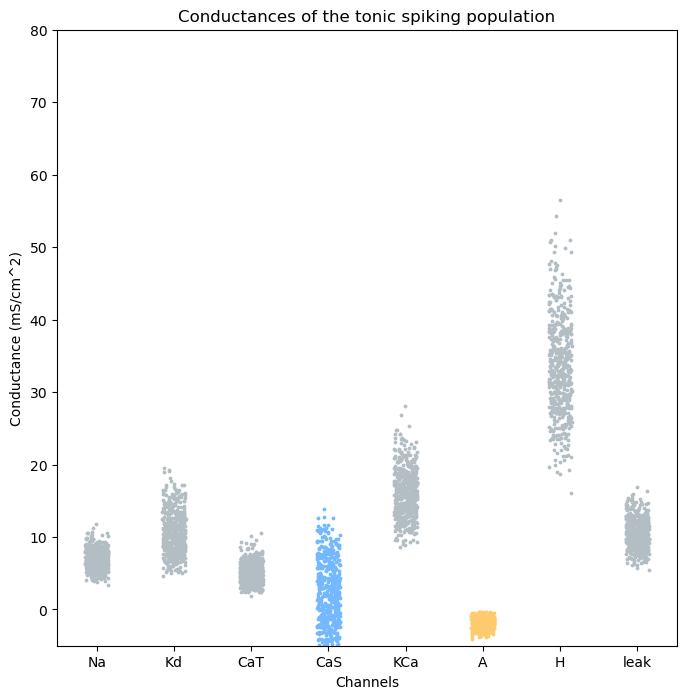

6817.658043569344
104.5622740539044
4.989172640922028
36.0199806023993
158.73720483615682
365.05786260394063
0.45227735829449967
0.010418317115544792


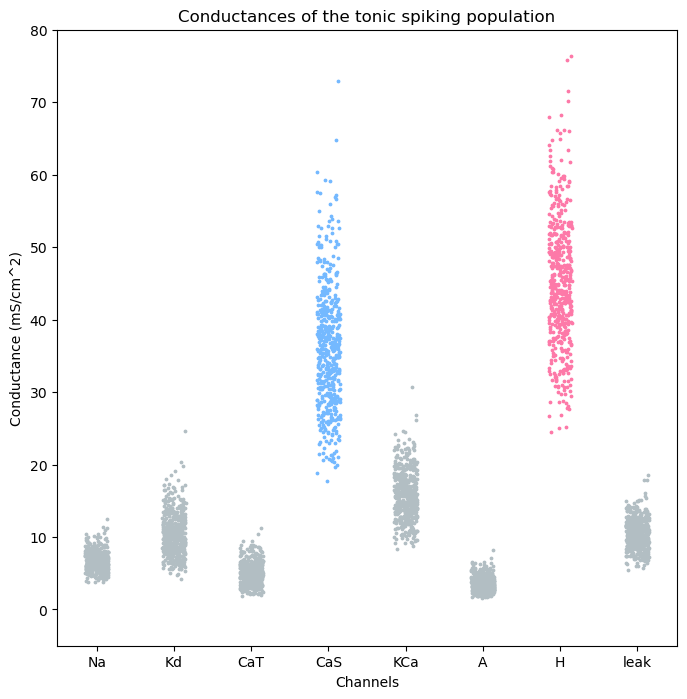

6807.153031233884
104.03575772899049
50.75956011939585
13.832798229737698
158.12061246533258
362.79747528778
0.4484933476037078
0.010417798748368637


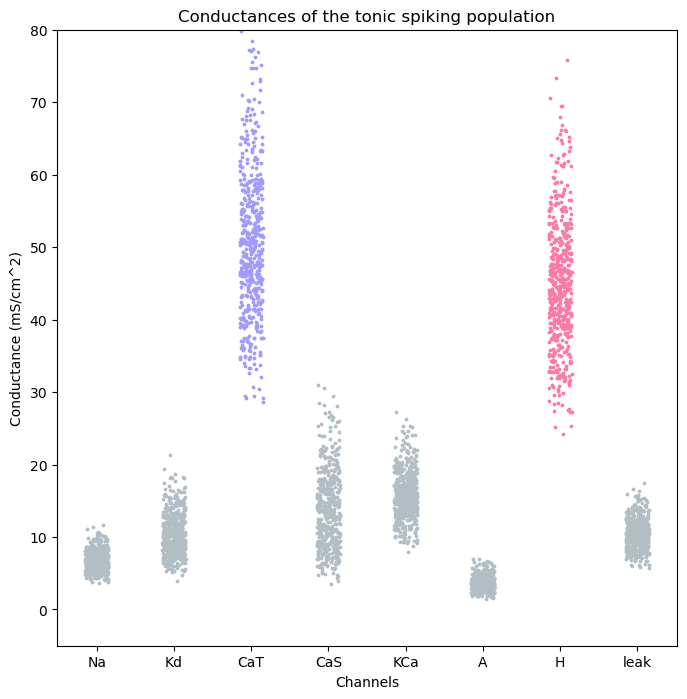

In [20]:
g_s_other_bursting = -5
g_u_other_bursting = 7.

N = 500

population_other_bursting1 = generate_neuromodulated_population(N, V_th, g_s_other_bursting, g_u_other_bursting, ['A', 'CaS'], clean=False)
print(population_other_bursting1.shape)


population_other_bursting2 = generate_neuromodulated_population(N, V_th, g_s_other_bursting, g_u_other_bursting, ['H', 'CaS'], clean=True)
print(population_other_bursting2.shape)


population_other_bursting3 = generate_neuromodulated_population(N, V_th, g_s_other_bursting, g_u_other_bursting, ['H', 'CaT'], clean=True)
print(population_other_bursting3.shape)
fig, ax1 = plt.subplots(figsize=(8, 8))

# Plot the CaS values
eps = 0.3
x_offset = (np.arange(N) - N/2) / N * eps

x_label = ['Na', 'Kd', 'CaT', 'CaS', 'KCa', 'A', 'H', 'leak']
scaling = [1e-3, 1e-1, 1, 1, 1e-1, 1e-2, 1e2, 1e3]

for i in range(len(population_other_bursting1[0])):
    m = np.mean(population_other_bursting1[:, i])
    print(m)
    c = '#b2bec3ff'
    if i == 3:
        c = '#74b9ff'
    if i == 5:
        c = '#fdcb6e'
    ax1.scatter(i + x_offset, population_other_bursting1[:, i]*scaling[i], color=c, s = 3)

ax1.set_xticks(range(len(x_label)))
ax1.set_xticklabels(x_label)
ax1.set_ylabel('Conductance (mS/cm^2)')
ax1.set_xlabel('Channels')
ax1.set_title('Conductances of the tonic spiking population')
ax1.set_ylim(-5, 80)

plt.savefig('figures/conductances_other_bursting1.svg')
plt.show()

fig, ax1 = plt.subplots(figsize=(8, 8))

# Plot the CaS values
eps = 0.3
x_offset = (np.arange(N) - N/2) / N * eps

x_label = ['Na', 'Kd', 'CaT', 'CaS', 'KCa', 'A', 'H', 'leak']

for i in range(len(population_other_bursting2[0])):
    m = np.mean(population_other_bursting2[:, i])
    print(m)
    c = '#b2bec3ff'
    if i == 3:
        # 74b9ffff
        c = '#74b9ff'
    if i == 6:
        # fd79a8ff
        c = '#fd79a8ff'
    ax1.scatter(i + x_offset, population_other_bursting2[:, i]*scaling[i], color=c, s = 3)

ax1.set_xticks(range(len(x_label)))
ax1.set_xticklabels(x_label)
ax1.set_ylabel('Conductance (mS/cm^2)')
ax1.set_xlabel('Channels')
ax1.set_title('Conductances of the tonic spiking population')
ax1.set_ylim(-5, 80)

plt.savefig('figures/conductances_other_bursting2.svg')
plt.show()


fig, ax1 = plt.subplots(figsize=(8, 8))

# Plot the CaS values
eps = 0.3
x_offset = (np.arange(N) - N/2) / N * eps

x_label = ['Na', 'Kd', 'CaT', 'CaS', 'KCa', 'A', 'H', 'leak']

for i in range(len(population_other_bursting3[0])):
    m = np.mean(population_other_bursting3[:, i])
    print(m)
    c = '#b2bec3ff'
    if i == 2:
        # a29bfeff
        c = '#a29bfeff'
    if i == 6:
        # fd79a8ff
        c = '#fd79a8ff'
    ax1.scatter(i + x_offset, population_other_bursting3[:, i]*scaling[i], color=c, s = 3)

ax1.set_xticks(range(len(x_label)))
ax1.set_xticklabels(x_label)
ax1.set_ylabel('Conductance (mS/cm^2)')
ax1.set_xlabel('Channels')
ax1.set_title('Conductances of the tonic spiking population')
ax1.set_ylim(-5, 80)

plt.savefig('figures/conductances_other_bursting3.svg')
plt.show()

(500, 8)
[1.00616052 2.66862321 1.36892169]
[10.23662017  1.02483471  1.35746851]


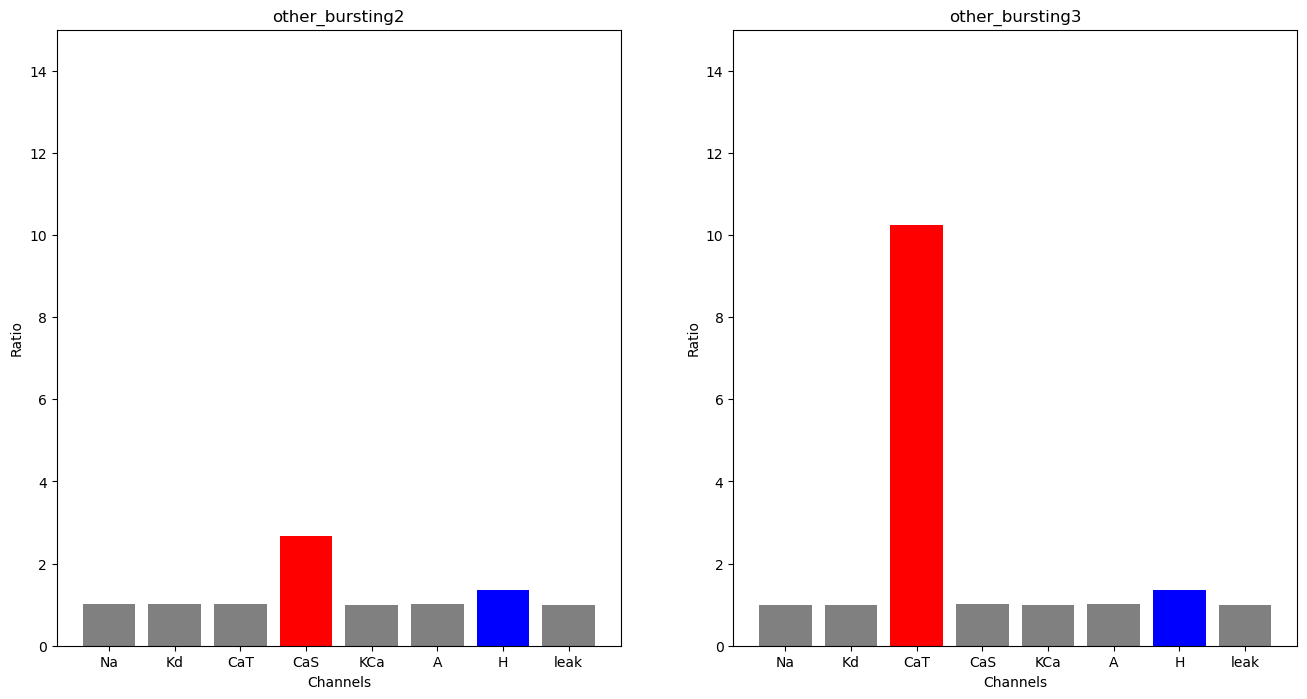

In [21]:
population_base = generate_neuromodulated_population(N, V_th, g_s_tonic_spiking, g_u_tonic_spiking, ['A', 'H'])
print(population_base.shape)

# compare the mean of the conductances with other_bursting2 and other_bursting3
fig, ax1 = plt.subplots(1, 2, figsize=(16, 8))

ratio_bursting2 = np.mean(population_other_bursting2, axis=0) / np.mean(population_base, axis=0)
ratio_bursting3 = np.mean(population_other_bursting3, axis=0) / np.mean(population_base, axis=0)
x_label = ['Na', 'Kd', 'CaT', 'CaS', 'KCa', 'A', 'H', 'leak']
colors_bursting2 = ['gray' if x not in ['CaS', 'H'] else 'blue' if x == 'H' else 'red' for x in x_label]
colors_bursting3 = ['gray' if x not in ['CaT', 'H'] else 'blue' if x == 'H' else 'red' for x in x_label]

#print the ratio for both for the CaT, CaS and H channels
print(ratio_bursting2[[2, 3, 6]])
print(ratio_bursting3[[2, 3, 6]])

ax1[0].bar(x_label, ratio_bursting2, color=colors_bursting2)
ax1[0].set_title('other_bursting2')
ax1[0].set_ylabel('Ratio')
ax1[0].set_xlabel('Channels')
ax1[0].set_ylim(0, 15)

ax1[1].bar(x_label, ratio_bursting3, color=colors_bursting3)
ax1[1].set_title('other_bursting3')
ax1[1].set_ylabel('Ratio')
ax1[1].set_xlabel('Channels')
ax1[1].set_ylim(0, 15)

plt.savefig('figures/conductances_ratio.svg')
plt.show()

(500, 8)
(500, 8)
(500, 8)
(4, 500)
(4, 500)
(4, 500)


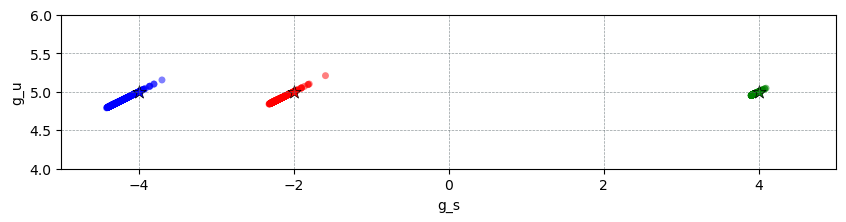

In [22]:
# resample each population with N = 500
N = 500

population_light_bursting = generate_neuromodulated_population(N, V_th, g_s_light_bursting, g_u_light_bursting, set_to_compensate)
print(population_light_bursting.shape)

population_strong_bursting = generate_neuromodulated_population(N, V_th, g_s_strong_bursting, g_u_strong_bursting, set_to_compensate)
print(population_strong_bursting.shape)

population_tonic_spiking = generate_neuromodulated_population(N, V_th, g_s_tonic_spiking, g_u_tonic_spiking, set_to_compensate)
print(population_tonic_spiking.shape)

# compute the DICs of light_bursting, strong_bursting, tonic_spiking

DIC_light_bursting = DICs(V_th, *(population_light_bursting.T), **get_default_parameters())
DIC_strong_bursting = DICs(V_th, *(population_strong_bursting.T), **get_default_parameters())
DIC_tonic_spiking = DICs(V_th, *(population_tonic_spiking.T), **get_default_parameters())

DIC_light_bursting = np.asarray(DIC_light_bursting).squeeze()
DIC_strong_bursting = np.asarray(DIC_strong_bursting).squeeze()
DIC_tonic_spiking = np.asarray(DIC_tonic_spiking).squeeze()

print(DIC_light_bursting.shape)
print(DIC_strong_bursting.shape)
print(DIC_tonic_spiking.shape)

# scatter plot of g_s and g_u
fig, ax = plt.subplots(1, 1, figsize=(10, 2))

sns.scatterplot(x=DIC_light_bursting[1, :], y=DIC_light_bursting[2, :], color='red', label='light_bursting', s=25, alpha=0.5, edgecolor='none', ax=ax)
sns.scatterplot(x=DIC_strong_bursting[1, :], y=DIC_strong_bursting[2, :], color='blue', label='strong_bursting', s=25, alpha=0.5, edgecolor='none', ax=ax)
sns.scatterplot(x=DIC_tonic_spiking[1, :], y=DIC_tonic_spiking[2, :], color='green', label='tonic_spiking', s=25, alpha=0.5, edgecolor='none', ax=ax)

# put stars on the target values
ax.scatter(g_s_light_bursting, g_u_light_bursting, color='red', marker='*', s=100, label='light_bursting target', edgecolors='black', linewidths=0.5)
ax.scatter(g_s_strong_bursting, g_u_strong_bursting, color='blue', marker='*', s=100, label='strong_bursting target', edgecolors='black', linewidths=0.5)
ax.scatter(g_s_tonic_spiking, g_u_tonic_spiking, color='green', marker='*', s=100, label='tonic_spiking target', edgecolors='black', linewidths=0.5)

# no legend
ax.legend().remove()

# nice grid
ax.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7, color='#636e72')

ax.set_xlabel('g_s')
ax.set_xlim(-5, 5)
ax.set_ylabel('g_u')
ax.set_ylim(4, 6)
plt.savefig('figures/g_s_g_u.svg')
plt.show()
